# BaseLine- On RoBerta Pretrained Language Model

In [1]:
from tqdm import tqdm 
import pandas as pd
import os, math
from functools import partial
import numpy as np
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from transformers import BertPreTrainedModel, BertConfig,AutoConfig,BertModel
from pytorch_transformers import BertTokenizer
from functools import partial
from transformers import AdamW, get_linear_schedule_with_warmup

torch.manual_seed(2342)

# 数据读取

In [68]:
with open('data/test.tsv', 'r', encoding='utf-8') as handler:
    lines = handler.read().split('\n')[1:-1]

    data = list()
    for line in tqdm(lines):
        sp = line.split('\t')
        if len(sp) != 2:
            print("Error: ", sp)
            continue
        data.append(sp)

test = pd.DataFrame(data)
test.columns = ['id', 'content']

#test = pd.read_csv('data/test.tsv', sep='\t')
#submit = pd.read_csv('data/submit_example.tsv', sep='\t')
#train = train[train['emotions'] != '']

100%|██████████| 21376/21376 [00:00<00:00, 316173.93it/s]


In [69]:
test

,id,content
0,1597_0001_A_1,（角色是:h2）会议室的投影仪上播放着h2在实验室做油霸实验的画面。
1,1597_0001_A_2,会议室的投影仪上播放着h2在实验室做油霸实验的画面。（角色是:h2）h2坐在录像机前戴上眼镜...
2,1597_0001_A_3,会议室的投影仪上播放着h2在实验室做油霸实验的画面。h2坐在录像机前戴上眼镜，调整了一下摄像...
3,1597_0001_A_4,会议室的投影仪上播放着h2在实验室做油霸实验的画面。h2坐在录像机前戴上眼镜，调整了一下摄像...
4,1597_0001_A_5,（角色是:）一个实验人员走过来看了看：油霸成功了。
...,...,...
21371,34914_0041_A_1599,大屏幕上是v2跑龙套的视频资料，底下的人大笑，视频中是v2当b3被吊起来，当替身被打之后拖走...
21372,34914_0041_A_1600,k3被拦在外面，v2向外走，一个s1跑进来，o3拽着s1。s1：梦姐，梦姐！o3放开s1后离...
21373,34914_0041_A_1601,v2爸爸看着v2和旁边人说笑的背影，v2妈妈爸爸眼中全是泪水。所有人站起来为v2鼓掌，v2捂...
21374,34914_0041_A_1602,v2爸爸看着v2和旁边人说笑的背影，v2妈妈爸爸眼中全是泪水。所有人站起来为v2鼓掌，v2捂...


# 数据处理
1. $BaseLine$的数据预处理中删掉了那些没有人物的句子，不过这种句子其实也算是上下文吧，我想是不是直接删掉不太好？<br/>
    **这让我产生了一个想法，我们是不是要把一个句子的上下文拼起来?!BaseLine中增加了text列我看很好！**<br/>
2. $BaseLine$中增加了text列，实现把人物和句子拼起来的功能...其实这一列就可以用来放上下文呀！
3. 记得把emotions转化为数字格式

In [9]:
train['aspect'] = train['character'].astype(str)

KeyError: 'character'

In [13]:
train

,id,content,emotions,love,joy,fright,anger,fear,sorrow
0,1171_0001_A_1,（角色是:o2）天空下着暴雨，o2正在给c1穿雨衣，他自己却只穿着单薄的军装，完全暴露在大雨之中。,"[0, 0, 0, 0, 0, 0]",0,0,0,0,0,0
1,1171_0001_A_2,（角色是:c1）天空下着暴雨，o2正在给c1穿雨衣，他自己却只穿着单薄的军装，完全暴露在大雨之中。,"[0, 0, 0, 0, 0, 0]",0,0,0,0,0,0
2,1171_0001_A_3,天空下着暴雨，o2正在给c1穿雨衣，他自己却只穿着单薄的军装，完全暴露在大雨之中。（角色是:...,"[0, 0, 0, 0, 0, 0]",0,0,0,0,0,0
3,1171_0001_A_4,天空下着暴雨，o2正在给c1穿雨衣，他自己却只穿着单薄的军装，完全暴露在大雨之中。（角色是:...,"[0, 0, 0, 0, 0, 0]",0,0,0,0,0,0
4,1171_0001_A_5,天空下着暴雨，o2正在给c1穿雨衣，他自己却只穿着单薄的军装，完全暴露在大雨之中。o2一手拿...,"[0, 0, 0, 0, 0, 0]",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
36777,34949_0180_A_1464,一句话，全靠你的一杆一舵。w2：是，教官。w2：2年级了。w2：是呀，你……他和屋子里的人一...,"[0, 2, 0, 0, 0, 0]",0,2,0,0,0,0
36778,34949_0180_A_1466,我是说……能让g3常住在你家吗？w2一下站了起来。他明白了b1的意思。这师徒二人在托孤。b1...,"[0, 2, 0, 0, 0, 0]",0,2,0,0,0,0
36779,34949_0180_A_1467,他明白了b1的意思。这师徒二人在托孤。b1：谢谢。b1向w2报告：已对准跑道，滑翔降落。一次...,"[0, 3, 0, 0, 0, 0]",0,3,0,0,0,0
36780,34949_0180_A_1468,一次性降落，各人的手已预放在自己负责的部件上。b1手握拉杆，对准跑道，沉着地降了下去。特写；...,"[0, 3, 0, 0, 0, 0]",0,3,0,0,0,0


In [70]:
#text列类似于构造特征
#train['text'] = train[ 'content'].astype(str)  +'[SEP]' + train['character'].astype(str)
#test['text'] = test['content'].astype(str) + ' [SEP] ' + test['character'].astype(str)
# emotion处理成数字列表
train['emotions'] = train['emotions'].apply(lambda x: [int(_i) for _i in x.split(',')])

train[['love', 'joy', 'fright', 'anger', 'fear', 'sorrow']] = train['emotions'].values.tolist()
test[['love', 'joy', 'fright', 'anger', 'fear', 'sorrow']] =[0,0,0,0,0,0]

train.to_csv('data/train.csv',columns=['id', 'content','love', 'joy', 'fright', 'anger', 'fear', 'sorrow'],
            sep='\t',
            index=False)

test.to_csv('data/test.csv',columns=['id', 'content','love', 'joy', 'fright', 'anger', 'fear', 'sorrow'],
            sep='\t',
            index=False)

In [86]:
test

,id,content,love,joy,fright,anger,fear,sorrow
0,1597_0001_A_1,（角色是:h2）会议室的投影仪上播放着h2在实验室做油霸实验的画面。,0,0,0,0,0,0
1,1597_0001_A_2,会议室的投影仪上播放着h2在实验室做油霸实验的画面。（角色是:h2）h2坐在录像机前戴上眼镜...,0,0,0,0,0,0
2,1597_0001_A_3,会议室的投影仪上播放着h2在实验室做油霸实验的画面。h2坐在录像机前戴上眼镜，调整了一下摄像...,0,0,0,0,0,0
3,1597_0001_A_4,会议室的投影仪上播放着h2在实验室做油霸实验的画面。h2坐在录像机前戴上眼镜，调整了一下摄像...,0,0,0,0,0,0
4,1597_0001_A_5,（角色是:）一个实验人员走过来看了看：油霸成功了。,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
21371,34914_0041_A_1599,大屏幕上是v2跑龙套的视频资料，底下的人大笑，视频中是v2当b3被吊起来，当替身被打之后拖走...,0,0,0,0,0,0
21372,34914_0041_A_1600,k3被拦在外面，v2向外走，一个s1跑进来，o3拽着s1。s1：梦姐，梦姐！o3放开s1后离...,0,0,0,0,0,0
21373,34914_0041_A_1601,v2爸爸看着v2和旁边人说笑的背影，v2妈妈爸爸眼中全是泪水。所有人站起来为v2鼓掌，v2捂...,0,0,0,0,0,0
21374,34914_0041_A_1602,v2爸爸看着v2和旁边人说笑的背影，v2妈妈爸爸眼中全是泪水。所有人站起来为v2鼓掌，v2捂...,0,0,0,0,0,0


# 定义数据集

## RoleDataSet
1. $RoleDataSet$ 每次返回的是**字典**，其中定义了以下变量：<br/>
① $texts$: 预处理后的文字段落<br/>
② $input\_ids$: 预处理后的文字段落的每个字的ids<br/>
③ $attention\_mask$: 由于Bert模型要求同一个batch输入长度相同，所以要把句子补充（<PAD>）到相同长度。mask则是把<PAD>标出来<br/>
④ 情感标签：一共包含6个键，'love', 'joy', 'fright', 'anger', 'fear', 'sorrow'<br/>

In [2]:
def encoder_plus(sentence, tokenizer, max_length=400, attention_mask=True, pad_to_max_length=True, add_special_tokens=True):
    '''
    实现自动补齐[PAD], 自动添加[CLS]、[SEP]功能；
    ---input---
    sentence: 单个句子（中文）
    max_length: 最大的对齐长度
    '''
    # 约束句子长度
    sentence_token = tokenizer.encode(sentence)[:max_length-2]
    # 增加特殊的CLS，SEP
    if add_special_tokens:
        sentence_token = tokenizer.add_special_tokens_single_sentence(sentence_token)
    mask = [1 for i in range(len(sentence_token))]
    # Padding
    if len(sentence_token)<max_length and pad_to_max_length:
        trueMask_length = len(sentence_token)
        sentence_token = sentence_token+[0 for i in range(max_length-trueMask_length)]
        mask = mask + [0 for i in range(max_length-trueMask_length)]
    id_array = [0 for i in range(len(sentence_token))]
    
    id_array = torch.tensor(id_array)
    if attention_mask:
        return {'input_ids':torch.tensor(sentence_token), 'attention_mask':torch.tensor(mask), 'id_1':id_array}
    else:
        return {'input_ids':torch.tensor(sentence_token)}

In [77]:
target_cols=['love', 'joy', 'fright', 'anger', 'fear', 'sorrow']
class RoleDataset(Dataset):
    def __init__(self, tokenizer, max_len=512, mode='train'):
        super(RoleDataset, self).__init__()
        if mode == 'train':
            self.data = pd.read_csv('data/train.csv',sep='\t')
            self.texts=self.data['content'].tolist()
            self.labels=self.data[target_cols].to_dict('records')
            self.tokenizer = tokenizer
            self.max_len = max_len
        else:
            self.data = pd.read_csv('data/test.csv',sep='\t')
        #self.texts: [strings, ]
        #self.labels: [{'love':, 'joy':, 'fright':, 'anger':, 'freat':, 'sorrow':}, ]
            self.texts=self.data['content'].tolist()
            self.labels=self.data[target_cols].to_dict('records')
            self.tokenizer = tokenizer
            self.max_len = max_len

    def __getitem__(self, index):
        text=str(self.texts[index])
        label=self.labels[index]
        encoding = encoder_plus(text, self.tokenizer, max_length=self.max_len)
        sample = {
            'texts': text,
            'input_ids': encoding['input_ids'],
            'attention_mask': encoding['attention_mask'],
            'token_type_ids': encoding['id_1']
        }

        for label_col in target_cols:
            sample[label_col] = torch.tensor(label[label_col]/3.0, dtype=torch.float)
        return sample

    def __len__(self):
        return len(self.texts)

## DataLoader

In [78]:
def create_dataloader(dataset, batch_size, mode='train'):
    shuffle = True if mode == 'train' else False
    if mode == 'train':
        data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    else:
        data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return data_loader

# 加载WWM-RoBerta Pretrained model

## RoBerta介绍
哈工大讯飞联合实验室发布的[预训练语言模型](http://github.com/ymcui/Chinese-BERT-wwm)。预训练的方式是采用$roberta$类似的方法，比如动态mask，更多的训练数据等等。在很多任务中，该模型效果要优于$bert-base-chinese$.<br/>
不过，由于RoBerta在国内下载的速度实在太慢，讯飞提供的也只有$Tensorflow$版本。因此，需要利用$Transformers$将其转换为$Pytorch$版本：<br/>
**进入pytorch_transformers:的site-package包**<br/>
​```cd C:\users\capricornguang\appdata\local\programs\python\python36\lib\site-packages\pytorch_transformers>​```<br/>
**安装好Pytorch，Tensorflow后执行如下命令**<br/>
​```
python .\convert_tf_checkpoint
_to_pytorch.py --tf_checkpoint_path=D:\NewDesk\Prog\CapricornGuang\ScripyEmotionCalculation_CCF\chinese_roberta_wwm_ext_L-12_H-768_A-12/
bert_model.ckpt --bert_config_file=D:\NewDesk\Prog\CapricornGuang\ScripyEmotionCalculation_CCF\chinese_roberta_wwm_ext_L-12_H-768_A-12/b
ert_config.json --pytorch_dump_path=D:\NewDesk\Prog\CapricornGuang\ScripyEmotionCalculation_CCF\chinese_roberta_wwm_ext_L-12_H-768_A-12\
pytorch_model.bin
​```
## Why WWM?
1. WWM 是 whloe-word-masked的缩写
2. **Whole Word Masking (wwm)，暂翻译为全词Mask或整词Mask**，是谷歌在2019年5月31日发布的一项BERT的升级版本，主要更改了原预训练阶段的训练样本生成策略。 简单来说，原有基于WordPiece的分词方式会把一个完整的词切分成若干个子词，在生成训练样本时，这些被分开的子词会随机被mask。 在全词Mask中，如果一个完整的词的部分WordPiece子词被mask，则同属该词的其他部分也会被mask，即全词Mask。<br/>
3. 需要注意的是，**这里的mask指的是广义的mask（替换成[MASK]；保持原词汇；随机替换成另外一个词）**，并非只局限于单词替换成[MASK]标签的情况

In [21]:
PRE_TRAINED_MODEL_NAME='BERT_wwm/'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
base_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at BERT_wwm/ were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## What is $tokenizer$ and $base\_model$?
### $tokenizer$ 是中文转$index$的类
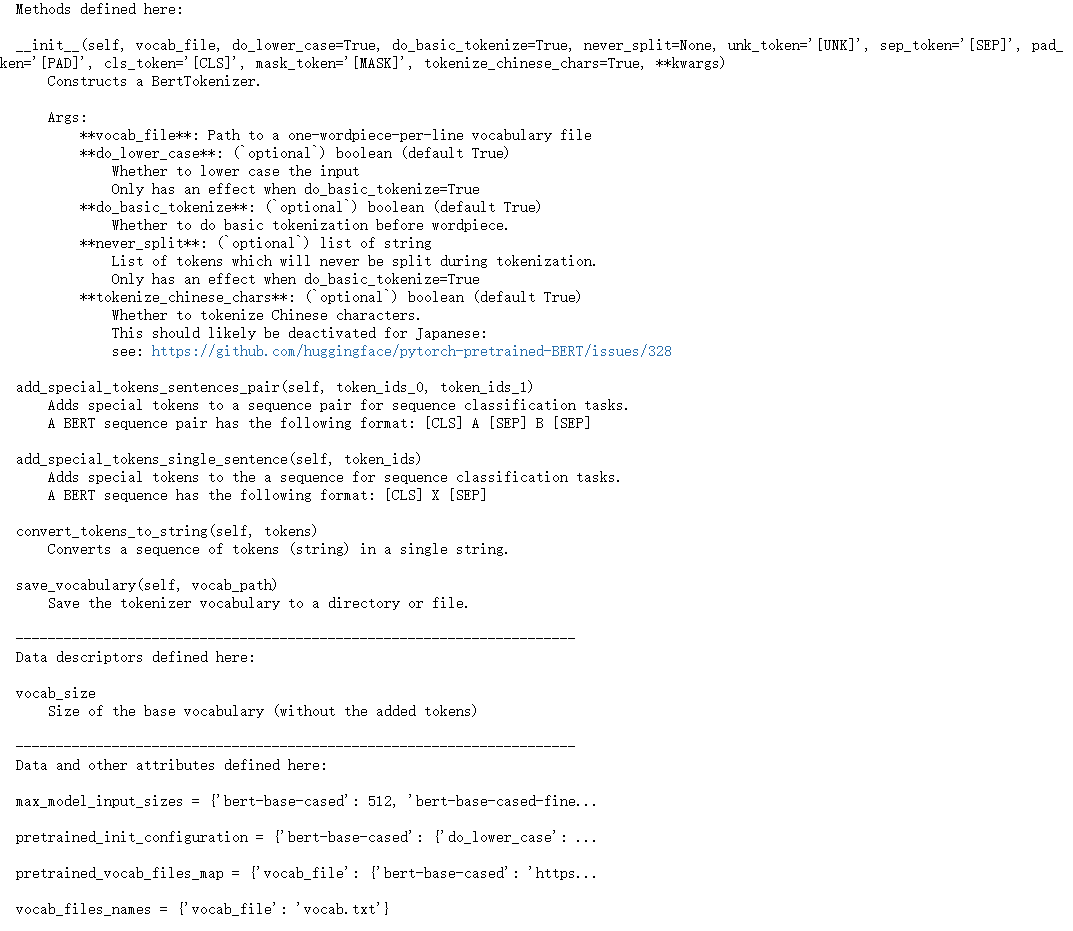
### $base\_model$ 是预训练好的$RoBerta$模型
①隐层维度：$hidden\_dim=768$<br/>
②模型输出：$outputs = (word\_embedding, sentence\_embedding)$<br/>
③**word_embedding**: $[batch\_size, seq\_len, hidden\_dim]$, <br/>
&ensp;&ensp;**sentence_embedding**: $[batch\_size, hidden\_dim]$

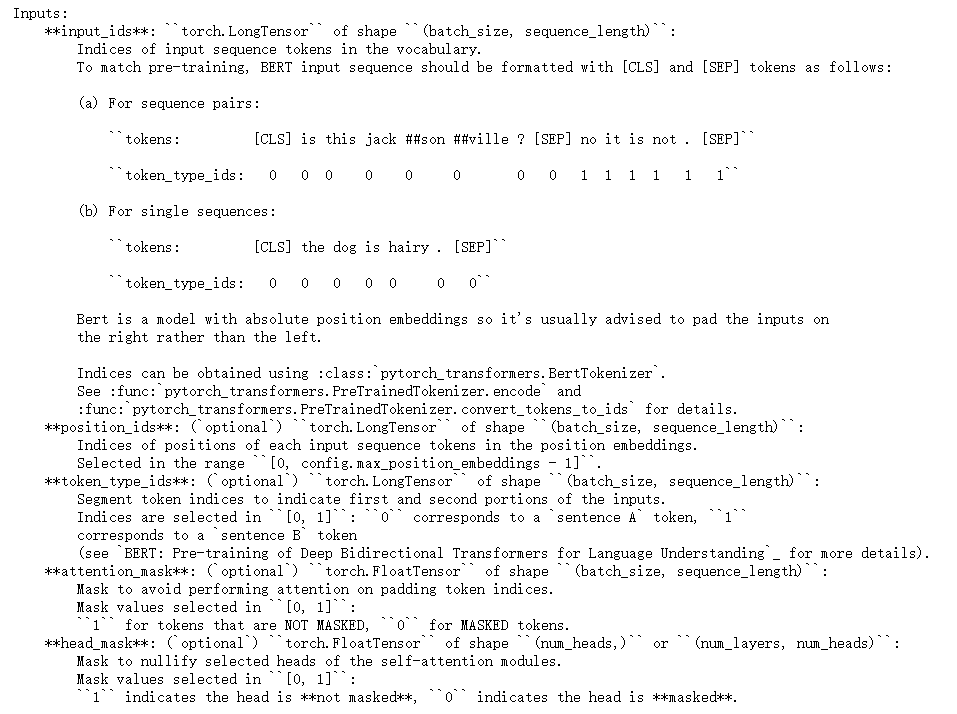

In [22]:
encode_dict = encoder_plus("自然语言处理", tokenizer) # Batch size 1
input_ids, attention_mask = encode_dict['input_ids'].unsqueeze(0), encode_dict['attention_mask'].unsqueeze(0)
outputs = base_model(input_ids=input_ids, attention_mask=attention_mask)
# last_hidden_states = outputs[0]  # The last hidden-state is the first element of the output tuple
sequence_output = outputs[0]
pooled_output = outputs[1]
print('output_size:',len(outputs))
print('word_embedding:',sequence_output.shape)    ## 字向量
print('sentence_embedding:',pooled_output.shape)      ## 句向量

output_size: 2
word_embedding: torch.Size([1, 400, 768])
sentence_embedding: torch.Size([1, 768])


# 搭建情感分类器

In [23]:
def init_params(module_lst):
    for module in module_lst:
        for param in module.parameters():
            if param.dim() > 1:
                torch.nn.init.xavier_uniform_(param)
    return

class EmotionClassifier(nn.Module):
    def __init__(self, n_classes, model_name):
        super(EmotionClassifier, self).__init__()
        config = AutoConfig.from_pretrained(model_name)
        config.update({"output_hidden_states": True,
                       "hidden_dropout_prob": 0.0,
                       "layer_norm_eps": 1e-7})
        self.base = BertModel.from_pretrained(model_name, config=config)

        dim = 1024 if 'large' in model_name else 768

        self.attention = nn.Sequential(
            nn.Linear(dim, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        # self.attention = AttentionHead(h_size=dim, hidden_dim=512, w_drop=0.0, v_drop=0.0)

        self.out_love = nn.Sequential(
            nn.Linear(dim, n_classes)
        )
        self.out_joy = nn.Sequential(
            nn.Linear(dim, n_classes)
        )
        self.out_fright = nn.Sequential(
            nn.Linear(dim, n_classes)
        )
        self.out_anger = nn.Sequential(
            nn.Linear(dim, n_classes)
        )
        self.out_fear = nn.Sequential(
            nn.Linear(dim, n_classes)
        )
        self.out_sorrow = nn.Sequential(
            nn.Linear(dim, n_classes)
        )

        init_params([self.out_love, self.out_joy, self.out_fright, self.out_anger,
                     self.out_fear,  self.out_sorrow, self.attention])

    def forward(self, input_ids, attention_mask):
        roberta_output = self.base(input_ids=input_ids,
                                   attention_mask=attention_mask)

        last_layer_hidden_states = roberta_output.hidden_states[-1]
        weights = self.attention(last_layer_hidden_states)
        # print(weights.size())
        context_vector = torch.sum(weights*last_layer_hidden_states, dim=1)
        # context_vector = weights

        love = self.out_love(context_vector)
        joy = self.out_joy(context_vector)
        fright = self.out_fright(context_vector)
        anger = self.out_anger(context_vector)
        fear = self.out_fear(context_vector)
        sorrow = self.out_sorrow(context_vector)

        return {
            'love': love, 'joy': joy, 'fright': fright,
            'anger': anger, 'fear': fear, 'sorrow': sorrow,
        }

# 模型训练

In [25]:
EPOCHS=1
weight_decay=0.0
data_path='data'
warmup_proportion=0.0
warm_up_ratio = 0
batch_size=6
lr = 3e-5
max_len = 512
warm_up_ratio = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 加载数据集

In [79]:
trainset = RoleDataset(tokenizer, max_len, mode='train')
train_loader = create_dataloader(trainset, batch_size, mode='train')

valset = RoleDataset(tokenizer, max_len, mode='test')
valid_loader = create_dataloader(valset, batch_size, mode='test')

## 模型与优化器载入

In [27]:
model = EmotionClassifier(n_classes=1, model_name=PRE_TRAINED_MODEL_NAME).to(device)
optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
total_steps = len(train_loader) * EPOCHS

criterion = nn.BCEWithLogitsLoss()

Some weights of the model checkpoint at BERT_wwm/ were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [28]:
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=warm_up_ratio*total_steps,
  num_training_steps=total_steps
)

## 正式训练

In [29]:
def do_train(model, date_loader, criterion, optimizer, scheduler, metric=None):
    model.train()
    global_step = 0
    tic_train = time.time()
    log_steps = 100
    for epoch in range(EPOCHS):
        losses = []
        for step, sample in enumerate(train_loader):
            input_ids = sample["input_ids"].cuda()
            attention_mask = sample["attention_mask"].cuda()

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            loss_love = criterion(outputs['love'], sample['love'].view(-1, 1).cuda())
            loss_joy = criterion(outputs['joy'], sample['joy'].view(-1, 1).cuda())
            loss_fright = criterion(outputs['fright'], sample['fright'].view(-1, 1).cuda())
            loss_anger = criterion(outputs['anger'], sample['anger'].view(-1, 1).cuda())
            loss_fear = criterion(outputs['fear'], sample['fear'].view(-1, 1).cuda())
            loss_sorrow = criterion(outputs['sorrow'], sample['sorrow'].view(-1, 1).cuda())
            loss = loss_love + loss_joy + loss_fright + loss_anger + loss_fear + loss_sorrow

            losses.append(loss.item())

            loss.backward()

#             nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

            global_step += 1

            if global_step % log_steps == 0:
                print("global step %d, epoch: %d, batch: %d, loss: %.5f, speed: %.2f step/s, lr: %.10f"
                      % (global_step, epoch, step, np.mean(losses), global_step / (time.time() - tic_train), 
                         float(scheduler.get_last_lr()[0])))


do_train(model, train_loader, criterion, optimizer, scheduler)

global step 100, epoch: 0, batch: 99, loss: 1.22365, speed: 1.95 step/s, lr: 0.0000295107
global step 200, epoch: 0, batch: 199, loss: 1.19148, speed: 1.94 step/s, lr: 0.0000290214
global step 300, epoch: 0, batch: 299, loss: 1.14108, speed: 1.94 step/s, lr: 0.0000285321
global step 400, epoch: 0, batch: 399, loss: 1.10972, speed: 1.94 step/s, lr: 0.0000280427
global step 500, epoch: 0, batch: 499, loss: 1.08016, speed: 1.94 step/s, lr: 0.0000275534
global step 600, epoch: 0, batch: 599, loss: 1.06371, speed: 1.94 step/s, lr: 0.0000270641
global step 700, epoch: 0, batch: 699, loss: 1.05456, speed: 1.94 step/s, lr: 0.0000265748
global step 800, epoch: 0, batch: 799, loss: 1.04199, speed: 1.94 step/s, lr: 0.0000260855
global step 900, epoch: 0, batch: 899, loss: 1.02594, speed: 1.94 step/s, lr: 0.0000255962
global step 1000, epoch: 0, batch: 999, loss: 1.01007, speed: 1.94 step/s, lr: 0.0000251068
global step 1100, epoch: 0, batch: 1099, loss: 0.99356, speed: 1.93 step/s, lr: 0.00002461

# 模型预测

## 代入数据到模型

In [57]:

def predict(model, test_loader):
    val_loss = 0
    test_pred = defaultdict(list)
    model.eval()
    model.cuda()
    for  batch in tqdm(test_loader):
        b_input_ids = batch['input_ids'].to(device)
        attention_mask = batch["attention_mask"].to(device)
        
        with torch.no_grad():
            logists = model(input_ids=b_input_ids, attention_mask=attention_mask)
            for col in target_cols:
                out2 = logists[col].sigmoid().squeeze(1)*3.0
                test_pred[col].extend(out2.cpu().numpy().tolist())

    return test_pred

In [80]:
from collections import defaultdict

hidden = []
test_pred = predict(model, valid_loader)

100%|██████████| 3563/3563 [10:54<00:00,  5.44it/s]


In [81]:
print(test_pred['love'][:10])
print(len(test_pred['love']))

[0.010582738555967808, 0.00797511450946331, 0.00976839754730463, 0.011197208426892757, 0.006996831391006708, 0.022553453221917152, 0.014442301355302334, 0.048518650233745575, 0.0227326899766922, 0.07903507351875305]
21376


In [82]:
def find_repeat()

SyntaxError: invalid syntax (<ipython-input-82-5b5071faec3c>, line 1)

In [83]:
from copy import deepcopy
submit = pd.read_csv('CleanedData/test_dataset.tsv', sep='\t')
label_preds = []
for col in target_cols:
    preds = test_pred[col]
    label_preds.append(preds)

def cloestInt(emotion):
    result = []
    for val in emotion:
        up_delta = math.ceil(val) - val
        down_delta = val-math.floor(val)
        middle_delta = abs(val-(math.ceil(val)+math.floor(val))/2)
        
        #elif middle_delta<0.1:
           # val = (math.ceil(val)+math.floor(val))/2
        result.append(str(val))
    return ','.join(result)

print(len(label_preds[0]))
sub = deepcopy(submit)
sub['emotion'] = np.stack(label_preds, axis=1).tolist()
sub['emotion'] = sub['emotion'].apply(cloestInt)
sub = sub.drop(['content','character'], axis=1)
sub.to_csv('baseline_{}.tsv'.format(PRE_TRAINED_MODEL_NAME.split('/')[0]), sep='\t', index=False)
sub.head(50)

21376


,id,emotion
0,1597_0001_A_1,"0.010582738555967808,0.01073436625301838,0.012..."
1,1597_0001_A_2,"0.00797511450946331,0.004059572704136372,0.007..."
2,1597_0001_A_3,"0.00976839754730463,0.012862754985690117,0.012..."
3,1597_0001_A_4,"0.011197208426892757,0.017391379922628403,0.02..."
4,1597_0001_A_5,"0.006996831391006708,0.5203379988670349,0.1839..."
5,1597_0001_A_6,"0.022553453221917152,0.005250307731330395,0.01..."
6,1597_0001_A_7,"0.014442301355302334,0.004057344514876604,0.01..."
7,1597_0001_A_8,"0.048518650233745575,0.24943430721759796,0.018..."
8,1597_0001_A_9,"0.0227326899766922,0.017114777117967606,0.0355..."
9,1597_0001_A_10,"0.07903507351875305,0.18907952308654785,0.0217..."


In [87]:
sub_visual = deepcopy(submit)
sub_visual['text'] = test['content']
sub_visual['emotion'] = np.stack(label_preds, axis=1).tolist()
sub_visual['emotion'] = sub_visual['emotion'].apply(lambda x: ','.join([str(i) for i in x]))
sub_visual.to_csv('baseline_{}_visual.tsv'.format(PRE_TRAINED_MODEL_NAME.split('/')[0]), sep='\t', index=False)
sub_visual.head()

,id,content,character,text,emotion
0,1597_0001_A_1,会议室的投影仪上播放着h2在实验室做油霸实验的画面。,h2,（角色是:h2）会议室的投影仪上播放着h2在实验室做油霸实验的画面。,"0.010582738555967808,0.01073436625301838,0.012..."
1,1597_0001_A_2,h2坐在录像机前戴上眼镜，调整了一下摄像机的位置。,h2,会议室的投影仪上播放着h2在实验室做油霸实验的画面。（角色是:h2）h2坐在录像机前戴上眼镜...,"0.00797511450946331,0.004059572704136372,0.007..."
2,1597_0001_A_3,h2：油霸实验，一月十五号，第五百七十三次，第六组。,h2,会议室的投影仪上播放着h2在实验室做油霸实验的画面。h2坐在录像机前戴上眼镜，调整了一下摄像...,"0.00976839754730463,0.012862754985690117,0.012..."
3,1597_0001_A_4,h2用滴管将几滴黑色的液体滴到了一个装着半杯油的杯子里，然后转身离开了，不一会儿，黑色的液体...,h2,会议室的投影仪上播放着h2在实验室做油霸实验的画面。h2坐在录像机前戴上眼镜，调整了一下摄像...,"0.011197208426892757,0.017391379922628403,0.02..."
4,1597_0001_A_5,一个实验人员走过来看了看：油霸成功了。,NaN,（角色是:）一个实验人员走过来看了看：油霸成功了。,"0.006996831391006708,0.5203379988670349,0.1839..."
